In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/titanic/train.csv
/kaggle/input/titanic/test.csv
/kaggle/input/titanic/gender_submission.csv


In [2]:
import pandas as pd
import numpy as np

np.random.randint(30)

11

In [3]:
path_1 = "/kaggle/input/titanic/train.csv"
path_2 = "/kaggle/input/titanic/test.csv"

train = pd.read_csv(path_1)
test = pd.read_csv(path_2)

In [4]:
train.describe().T

,count,mean,std,min,25%,50%,75%,max
PassengerId,891.0,446.000000,257.353842,1.00,223.5000,446.0000,668.5,891.0000
Survived,891.0,0.383838,0.486592,0.00,0.0000,0.0000,1.0,1.0000
Pclass,891.0,2.308642,0.836071,1.00,2.0000,3.0000,3.0,3.0000
Age,714.0,29.699118,14.526497,0.42,20.1250,28.0000,38.0,80.0000
SibSp,891.0,0.523008,1.102743,0.00,0.0000,0.0000,1.0,8.0000
Parch,891.0,0.381594,0.806057,0.00,0.0000,0.0000,0.0,6.0000
Fare,891.0,32.204208,49.693429,0.00,7.9104,14.4542,31.0,512.3292


In [5]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [6]:
train.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')

In [7]:
ytrain = train['Survived']
train = train.drop(['Name','Ticket','PassengerId','Cabin','Survived'], axis=1)

In [8]:
train.columns

Index(['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked'], dtype='object')

In [9]:
from sklearn.preprocessing import OrdinalEncoder
from sklearn.impute import SimpleImputer

In [10]:
encoder_ = OrdinalEncoder()
lista = ["Sex", "Embarked"]
train[lista]= encoder_.fit_transform(train[lista])
imputer_ = SimpleImputer(strategy='median')
train[['Age','Embarked']] = imputer_.fit_transform(train[['Age','Embarked']])

In [11]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Pclass    891 non-null    int64  
 1   Sex       891 non-null    float64
 2   Age       891 non-null    float64
 3   SibSp     891 non-null    int64  
 4   Parch     891 non-null    int64  
 5   Fare      891 non-null    float64
 6   Embarked  891 non-null    float64
dtypes: float64(4), int64(3)
memory usage: 48.9 KB


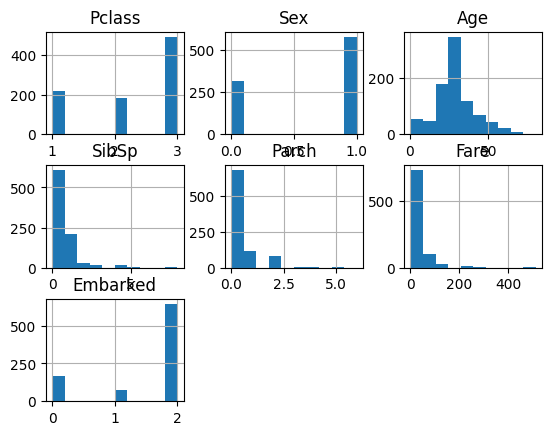

In [12]:
import matplotlib.pyplot as plt
train.hist()
plt.show()

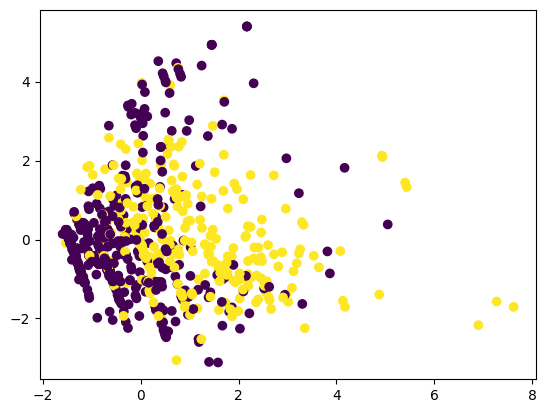

In [13]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

sca_ = StandardScaler()
red_ = PCA(n_components = 2)
ztrain = red_.fit_transform(sca_.fit_transform(train))
ztrain.shape
plt.scatter(ztrain[:,0],ztrain[:,1],c=ytrain)

In [14]:
import cudf, cupy as cp
from cuml.manifold import UMAP
import matplotlib.pyplot as plt

print("cudf:", cudf.__version__)


cudf: 25.02.02


In [15]:
train

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,3,1.0,22.0,1,0,7.2500,2.0
1,1,0.0,38.0,1,0,71.2833,0.0
2,3,0.0,26.0,0,0,7.9250,2.0
3,1,0.0,35.0,1,0,53.1000,2.0
4,3,1.0,35.0,0,0,8.0500,2.0
...,...,...,...,...,...,...,...
886,2,1.0,27.0,0,0,13.0000,2.0
887,1,0.0,19.0,0,0,30.0000,2.0
888,3,0.0,28.0,1,2,23.4500,2.0
889,1,1.0,26.0,0,0,30.0000,0.0


In [16]:
from cuml.manifold import UMAP
import time

umap = UMAP(
    n_neighbors=500,     # más pequeño => preserva estructura local
    min_dist=0.2,       # menor => clusters más compactos
    n_components=2,     # proyección 2D
#    metric="euclidean", # métrica por defecto
#    init="spectral",    # inicialización estable
#    random_state=42
)
sca_ = StandardScaler()
z = umap.fit_transform(sca_.fit_transform(train))
z = np.asarray(z)
z

[2025-10-26 21:08:16.262] [CUML] [info] Building knn graph using brute force


array([[ 1.9794655 ,  5.1082935 ],
       [-2.395625  ,  5.45924   ],
       [-5.221134  ,  6.5474377 ],
       ...,
       [-3.6226149 ,  6.540124  ],
       [-1.4663267 ,  5.898838  ],
       [-0.60153675,  8.204677  ]], dtype=float32)

In [17]:
ytrain1 = np.asarray(ytrain)
ytrain1

array([0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1,
       1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1,
       1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1,
       1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0,
       0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0,
       1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0,
       1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1,
       0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0,
       0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0,
       1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1,

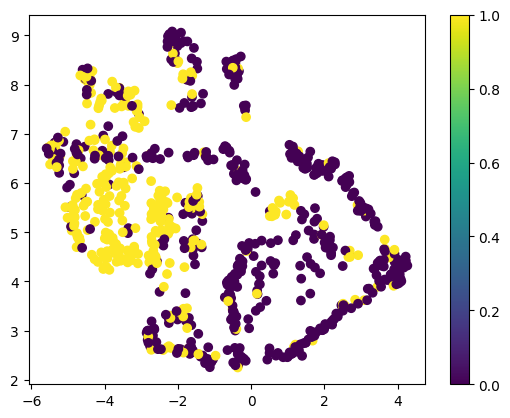

In [18]:
plt.scatter(z[:,0],z[:,1],c=ytrain1)
plt.colorbar()
plt.show()

## Calcular rendimiento en cojunto de test


🔍 Entrenando modelo 1/3: MinMax_Logistic
Fitting 5 folds for each of 6 candidates, totalling 30 fits

🔍 Entrenando modelo 2/3: MinMax_SGD
Fitting 5 folds for each of 5 candidates, totalling 25 fits

🔍 Entrenando modelo 3/3: MinMax_SVCrbf
Fitting 5 folds for each of 12 candidates, totalling 60 fits

✅ Modelos guardados en titanic_models.pkl

📊 Evaluando modelo MinMax_Logistic (1/3)
Accuracy: 78.32%
Mejores parámetros: {'cla__C': 10}


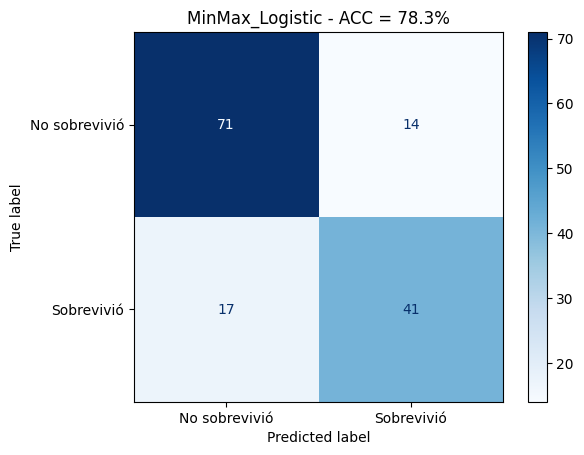

               precision    recall  f1-score   support

No sobrevivió       0.81      0.84      0.82        85
   Sobrevivió       0.75      0.71      0.73        58

     accuracy                           0.78       143
    macro avg       0.78      0.77      0.77       143
 weighted avg       0.78      0.78      0.78       143


📊 Evaluando modelo MinMax_SGD (2/3)
Accuracy: 76.92%
Mejores parámetros: {'cla__alpha': 0.01}


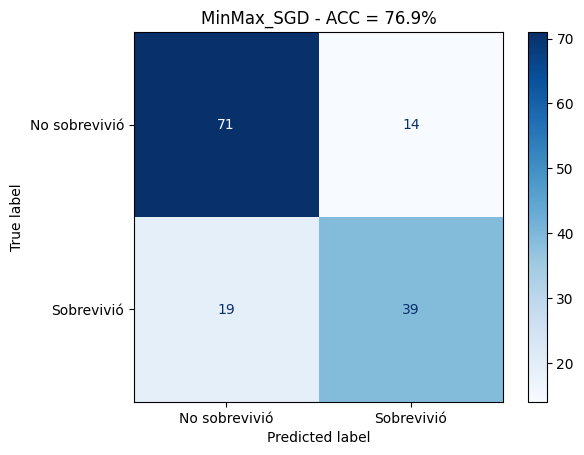

               precision    recall  f1-score   support

No sobrevivió       0.79      0.84      0.81        85
   Sobrevivió       0.74      0.67      0.70        58

     accuracy                           0.77       143
    macro avg       0.76      0.75      0.76       143
 weighted avg       0.77      0.77      0.77       143


📊 Evaluando modelo MinMax_SVCrbf (3/3)
Accuracy: 75.52%
Mejores parámetros: {'cla__C': 100, 'cla__gamma': 1}


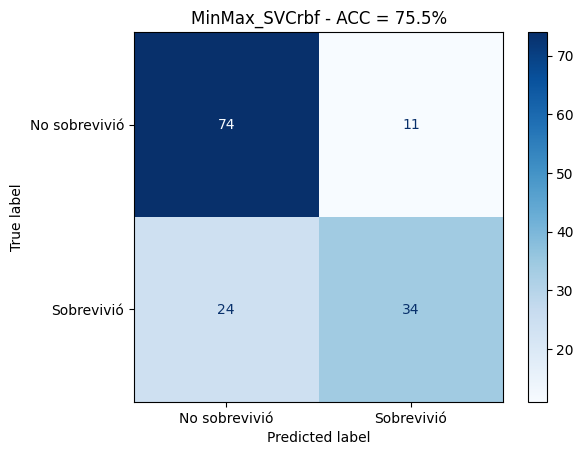

               precision    recall  f1-score   support

No sobrevivió       0.76      0.87      0.81        85
   Sobrevivió       0.76      0.59      0.66        58

     accuracy                           0.76       143
    macro avg       0.76      0.73      0.73       143
 weighted avg       0.76      0.76      0.75       143



In [19]:
#%% ===================== 1. Importación y carga =====================
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, classification_report, ConfusionMatrixDisplay
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.svm import SVC
import matplotlib.pyplot as plt
import joblib

# Rutas
path_1 = "/kaggle/input/titanic/train.csv"
path_2 = "/kaggle/input/titanic/test.csv"

train = pd.read_csv(path_1)
test = pd.read_csv(path_2)

#%% ===================== 2. Limpieza de datos =====================

# Seleccionamos solo algunas columnas útiles
cols = ['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked', 'Survived']
train = train[cols]

# Eliminar filas con valores nulos
train = train.dropna()

# Convertir variables categóricas a numéricas
train['Sex'] = train['Sex'].map({'male': 0, 'female': 1})
train['Embarked'] = train['Embarked'].map({'C': 0, 'Q': 1, 'S': 2})

# Separar variables predictoras y objetivo
X = train.drop('Survived', axis=1)
y = train['Survived']

# Dividir en entrenamiento y prueba (porcentaje del original)
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

#%% ===================== 3. Definir modelos y parámetros =====================

from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.svm import SVC

steps = [
    [('nor', MinMaxScaler()), ('cla', LogisticRegression(max_iter=1000))],
    [('nor', MinMaxScaler()), ('cla', SGDClassifier(max_iter=1000, tol=1e-3))],
    [('nor', MinMaxScaler()), ('cla', SVC())]
]

parameters = [
    {'cla__C': [1e-3, 1e-2, 1e-1, 1, 10, 1e2]},  # LogisticRegression
    {'cla__alpha': [1e-3, 1e-2, 1e-1, 1, 10]},   # SGDClassifier
    {'cla__C': [1, 10, 100], 'cla__gamma': [1e-3, 1e-2, 1e-1, 1]}  # SVC
]

label_models = ['MinMax_Logistic', 'MinMax_SGD', 'MinMax_SVCrbf']
models = []

filename = 'titanic_models'

#%% ===================== 4. Entrenamiento con GridSearchCV =====================

for i in range(len(steps)):
    print(f'\n🔍 Entrenando modelo {i+1}/{len(steps)}: {label_models[i]}')
    grid_search = GridSearchCV(
        Pipeline(steps[i]),
        parameters[i],
        n_jobs=-1,
        cv=5,
        scoring='accuracy',
        refit=True,
        verbose=1
    )
    grid_search.fit(Xtrain, ytrain)
    models.append(grid_search)

# Guardar todos los modelos
joblib.dump(models, filename + ".pkl")
print("\n✅ Modelos guardados en", filename + ".pkl")

#%% ===================== 5. Evaluación sobre Xtest =====================

my_model_loaded = joblib.load(filename + ".pkl")

for i in range(len(my_model_loaded)):
    print(f'\n📊 Evaluando modelo {label_models[i]} ({i+1}/{len(my_model_loaded)})')

    y_pred = my_model_loaded[i].best_estimator_.predict(Xtest)
    acc = accuracy_score(ytest, y_pred)

    print(f"Accuracy: {acc*100:.2f}%")
    print("Mejores parámetros:", my_model_loaded[i].best_params_)

    # Matriz de confusión
    disp = ConfusionMatrixDisplay.from_predictions(
        ytest, y_pred,
        display_labels=["No sobrevivió", "Sobrevivió"],
        cmap="Blues",
        values_format="d"
    )
    disp.ax_.set_title(f"{label_models[i]} - ACC = {acc*100:.1f}%")
    plt.show()

    # Reporte de clasificación
    cr = classification_report(ytest, y_pred, target_names=["No sobrevivió", "Sobrevivió"])
    print(cr)


## Curva ROC tradicional

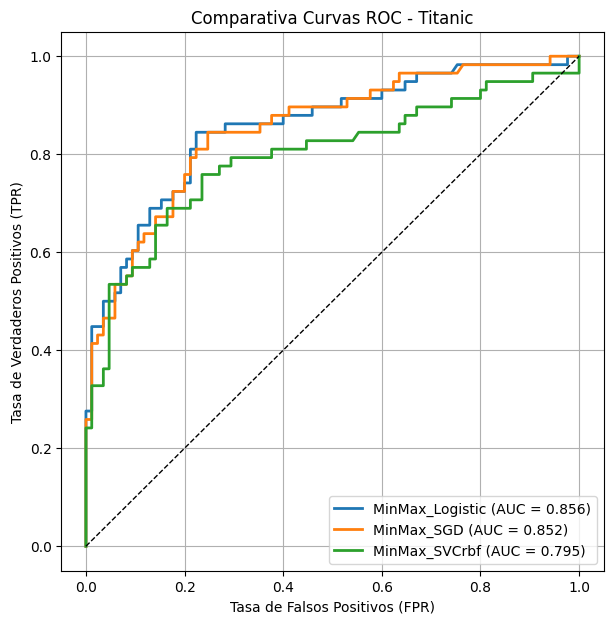

In [20]:
#%% ===================== 6. Curva ROC comparativa =====================
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Cargar modelos previamente entrenados
my_model_loaded = joblib.load(filename + ".pkl")

plt.figure(figsize=(7,7))

for i, model in enumerate(my_model_loaded):
    # Obtener probabilidades de la clase positiva (sobrevive)
    # Algunos modelos (como SVC) necesitan probability=True para esto
    try:
        y_score = model.best_estimator_.predict_proba(Xtest)[:, 1]
    except:
        # Si no tiene predict_proba, usamos decision_function (valores de distancia)
        y_score = model.best_estimator_.decision_function(Xtest)

    # Calcular puntos ROC
    fpr, tpr, _ = roc_curve(ytest, y_score)
    roc_auc = auc(fpr, tpr)

    # Dibujar curva ROC
    plt.plot(fpr, tpr, lw=2,
             label=f'{label_models[i]} (AUC = {roc_auc:.3f})')

# Línea diagonal (clasificador aleatorio)
plt.plot([0, 1], [0, 1], 'k--', lw=1)

# Configuración del gráfico
plt.xlabel('Tasa de Falsos Positivos (FPR)')
plt.ylabel('Tasa de Verdaderos Positivos (TPR)')
plt.title('Comparativa Curvas ROC - Titanic')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()



In [23]:
#librerias a importar
import os
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels
from sklearn.model_selection import train_test_split, GridSearchCV,cross_val_score, cross_val_predict
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.pipeline import Pipeline
from sklearn.datasets import fetch_lfw_people
from sklearn.metrics import roc_curve, auc
from itertools import cycle

import warnings
warnings.filterwarnings("ignore")

#crear carpeta resultados
try:
  os.mkdir('results')
except:
  print("Carpeta results ya existe")

#%%  guardar figuras
def save_fig(path_img,fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(path_img, fig_id + "." + fig_extension)
    print("Guardando...", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)
    files.download(path)

import seaborn as sns

#curvas roc multiclase
def roc_auc_mc(roc_auc,fpr,tpr,n_classes,title,path_img):
    lw = 2
    # Falsos positivos
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))
    # roc
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(n_classes):
        mean_tpr += np.interp(all_fpr, fpr[i], tpr[i]) #interpolar para suavizar
    # promediado sobre numero de clases
    mean_tpr /= n_classes
    fpr["macro"] = all_fpr
    tpr["macro"] = mean_tpr
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

    # graficar
    plt.figure(figsize=(6,6))
    plt.plot(fpr["micro"], tpr["micro"],
             label='micro-average ROC curve (area = {0:0.2f})'
                   ''.format(roc_auc["micro"]),
             color='deeppink', linestyle=':', linewidth=4)

    plt.plot(fpr["macro"], tpr["macro"],
             label='macro-average ROC curve (area = {0:0.2f})'
                   ''.format(roc_auc["macro"]),
             color='navy', linestyle=':', linewidth=4)

    #colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
    colors = sns.color_palette(None, n_classes)
    for i, color in zip(range(n_classes), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=lw,
                 label='AUC_class_{0} (area = {1:0.2f})'
                 ''.format(i, roc_auc[i]))

    plt.plot([0, 1], [0, 1], 'k--', lw=lw)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(title)
    plt.legend(loc="best")#,bbox_to_anchor=(1.4, 0.75))
    plt.show()


#matriz confusión = #[[TN FP][FN TP]]
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--') #clasificador aleatorio
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Positive Rate', fontsize=16)
    plt.ylabel('True Positive Rate', fontsize=16)


# ROC curve and ROC
def roc_multiclass(ytrue,yscore):
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    n_classes = ytrue.shape[1]
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(ytrue[:, i], yscore[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Calcular micro-average ROC curve y ROC area
    fpr["micro"], tpr["micro"], _ = roc_curve(ytrue.ravel(), yscore.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
    return roc_auc, fpr, tpr, n_classes

def plot_confusion_matrix(y_true, y_pred, classes,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    gráfica la matriz de confusión con y sin normalización
    """
    if not title:
        title = 'Matriz de confusión'

    # calcular matriz de confusión
    cm = 100*confusion_matrix(y_true, y_pred,normalize="true")
    # se identifican las etiquetas en los datos
    classes = classes[unique_labels(y_true, y_pred)]

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # mostrar ticks
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='Etiqueta original',
           xlabel='Predicción')

    # Rotar ticks
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # textos.
    fmt = '.1f'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

Carpeta results ya existe


In [22]:
#%% Escoger modelo por gridsearchCV utilizando pipeline
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
import joblib

#se crean listas de steps (pipelines)
steps=[[('nor', MinMaxScaler()),
        ('cla', LogisticRegression())], #Pipeline1
       [('nor',  MinMaxScaler()),
        ('cla', SGDClassifier())],#Pipeline2
        [('nor',MinMaxScaler()),
         ('cla', SVC())]#Pipeline3
      ]

parameters = [{
              'cla__n_neigbors': [1, 3, 5, 11, 13, 99],#Pipeline1 - hyperparametros
              },
              {
              'cla__alpha': [1e-3,1e-2,1e-1,1,10,1e2,1e3],#Pipeline2 - hyperparametros
              },
              {
             'cla__C': [1,10,1e2,1e3,1e4],
             'cla__gamma': [1e-3, 1e-2, 1e-1,1, 10]    #Pipeline2 - hyperparametros
             }
             ]

label_models = ['MinMax_Logistic','MinMax_SGD', 'MinMax_SVCrbf']

models = []
filename = 'results/lfw_models'
for i in range(len(steps)): # recorrer modelos según lista pipeline
    print('modelo %d/%d' % (i+1,len(steps)))
    grid_search = GridSearchCV(Pipeline(steps[i]), parameters[i], n_jobs=-1,cv=5,
                                scoring='accuracy',refit= True,verbose=10)#gridsearch para modelo i
    grid_search.fit(Xtrain, ytrain)
    #mejor modelo entrenado
    models += [grid_search] #guardar modelos
    joblib.dump(models,filename+".pkl")

modelo 1/3
Fitting 5 folds for each of 6 candidates, totalling 30 fits


ValueError: Invalid parameter 'n_neigbors' for estimator LogisticRegression(). Valid parameters are: ['C', 'class_weight', 'dual', 'fit_intercept', 'intercept_scaling', 'l1_ratio', 'max_iter', 'multi_class', 'n_jobs', 'penalty', 'random_state', 'solver', 'tol', 'verbose', 'warm_start'].